<a href="https://colab.research.google.com/github/Vivekkrguptajio/Movie-Recommendation-System/blob/main/MovieRecommendationSystem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Movie Recommendation System



Objective

To create a movie recommendation system that suggests movies to users based on their past preferences. We can use collaborative filtering or content-based filtering for this purpose. For simplicity, let's use a popular dataset called the MovieLens dataset, which contains ratings of movies by users.


Data Source

We'll use the MovieLens dataset, which is available in various sizes. For this example, we'll use the "MovieLens 100K" dataset, which contains 100,000 ratings by 943 users for 1,682 movies. This dataset can be found https://grouplens.org/datasets/movielens/100k/.

Import Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import TruncatedSVD


Import Data

In [2]:
!wget http://files.grouplens.org/datasets/movielens/ml-100k.zip
!unzip ml-100k.zip


--2024-06-14 18:02:13--  http://files.grouplens.org/datasets/movielens/ml-100k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4924029 (4.7M) [application/zip]
Saving to: ‘ml-100k.zip’

ml-100k.zip         100%[===================>]   4.70M  20.0MB/s    in 0.2s    

2024-06-14 18:02:13 (20.0 MB/s) - ‘ml-100k.zip’ saved [4924029/4924029]

Archive:  ml-100k.zip
   creating: ml-100k/
  inflating: ml-100k/allbut.pl       
  inflating: ml-100k/mku.sh          
  inflating: ml-100k/README          
  inflating: ml-100k/u.data          
  inflating: ml-100k/u.genre         
  inflating: ml-100k/u.info          
  inflating: ml-100k/u.item          
  inflating: ml-100k/u.occupation    
  inflating: ml-100k/u.user          
  inflating: ml-100k/u1.base         
  inflating: ml-100k/u1.test         
  inflating: ml-100k/u2.base

In [3]:
ratings_file = 'ml-100k/u.data'
movies_file = 'ml-100k/u.item'

ratings = pd.read_csv(ratings_file, sep='\t', names=['user_id', 'movie_id', 'rating', 'timestamp'])
movies = pd.read_csv(movies_file, sep='|', encoding='ISO-8859-1', names=['movie_id', 'title'], usecols=[0, 1])


Describe Data

In [4]:
print("Ratings DataFrame:")
print(ratings.head())

print("\nMovies DataFrame:")
print(movies.head())


Ratings DataFrame:
   user_id  movie_id  rating  timestamp
0      196       242       3  881250949
1      186       302       3  891717742
2       22       377       1  878887116
3      244        51       2  880606923
4      166       346       1  886397596

Movies DataFrame:
   movie_id              title
0         1   Toy Story (1995)
1         2   GoldenEye (1995)
2         3  Four Rooms (1995)
3         4  Get Shorty (1995)
4         5     Copycat (1995)


Data Visualization

<ipython-input-5-273acdf98384>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=ratings, x='rating', palette='viridis')


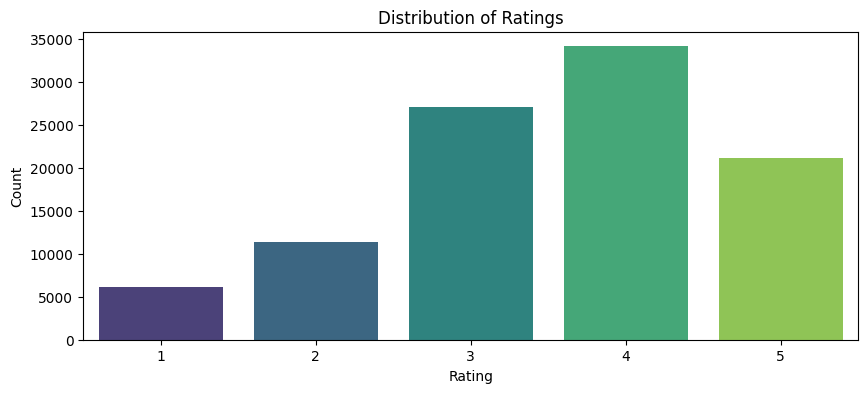

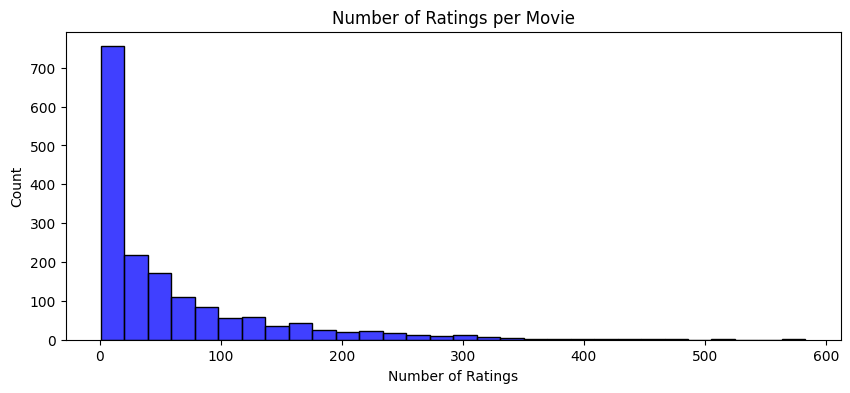

In [5]:
plt.figure(figsize=(10, 4))

# Distribution of ratings
sns.countplot(data=ratings, x='rating', palette='viridis')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

# Number of ratings per movie
ratings_per_movie = ratings.groupby('movie_id').size()
plt.figure(figsize=(10, 4))
sns.histplot(ratings_per_movie, bins=30, kde=False, color='blue')
plt.title('Number of Ratings per Movie')
plt.xlabel('Number of Ratings')
plt.ylabel('Count')
plt.show()


Data Preprocessing

In [6]:
merged_ratings = pd.merge(ratings, movies, on='movie_id')
user_item_matrix = merged_ratings.pivot_table(index='user_id', columns='title', values='rating')
user_item_matrix.fillna(0, inplace=True)


Define Target Variable (y) and Feature Variables (X)

In the context of building a movie recommendation system, defining the target variable (y) and the feature variables (X) is crucial to understand how the model will be trained and what it aims to predict. Let’s break this down for a collaborative filtering-based recommendation system:

Target Variable (y) and Feature Variables (X)
In recommendation systems, especially those based on collaborative filtering, the typical setup is as follows:

Feature Variables (X): This represents the known ratings given by users to movies. These ratings are used to learn the underlying patterns in user preferences and movie characteristics.

Target Variable (y): The target is the unknown or missing ratings that we want to predict for each user-movie pair. This is what the recommendation system aims to predict to suggest new movies to the user.

Given the user-item interaction matrix, we will often treat the observed part of this matrix as our feature set
𝑋
X and predict the unobserved part as our target
𝑦
y.

In Practice
For our recommendation system using the MovieLens dataset, let’s elaborate on how to define
𝑋
X and
𝑦
y.

Step-by-Step Process
Load and Merge Data:

Combine user ratings with movie titles to create a complete view of the interactions.
Create the User-Item Matrix:

Transform the combined dataset into a matrix where rows represent users, columns represent movies, and the cell values represent the ratings. Missing values indicate that the user has not rated the movie.
Split the Data:

Separate the known ratings into a training set (used to learn the model) and a test set (used to evaluate the model’s predictions).

Train Test Split

In [7]:
def train_test_split_ratings(X, test_size=0.2):
    X_train = X.copy()
    X_test = np.zeros(X.shape)
    for user in range(X.shape[0]):
        non_zero_indices = X[user, :].nonzero()[0]
        test_indices = np.random.choice(non_zero_indices, size=int(test_size * len(non_zero_indices)), replace=False)
        X_train[user, test_indices] = 0
        X_test[user, test_indices] = X[user, test_indices]
    return X_train, X_test

X = user_item_matrix.values
X_train, X_test = train_test_split_ratings(X, test_size=0.2)


Modeling

In [8]:
n_components = 20
svd = TruncatedSVD(n_components=n_components)
U = svd.fit_transform(X_train)
Sigma = np.diag(svd.singular_values_)
Vt = svd.components_

# Reconstructing the matrix
X_pred = np.dot(np.dot(U, Sigma), Vt)


Model Evaluation

In [9]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

test_nonzero_indices = X_test.nonzero()
predicted = X_pred[test_nonzero_indices]
actual = X_test[test_nonzero_indices]

error = rmse(actual, predicted)
print(f'RMSE on test set: {error}')


RMSE on test set: 640.4075985667058


Prediction

In [10]:
def recommend_movies(user_id, X_pred, movies, user_item_matrix, n_recommendations=5):
    user_ratings = X_pred[user_id - 1]
    known_ratings = user_item_matrix.iloc[user_id - 1].values

    user_ratings[known_ratings != 0] = -1

    top_indices = user_ratings.argsort()[-n_recommendations:][::-1]
    recommendations = movies.iloc[top_indices]

    return recommendations

user_id = 1
recommendations = recommend_movies(user_id, X_pred, movies, user_item_matrix)
print(f"Recommendations for User {user_id}:")
print(recommendations)


Recommendations for User 1:
      movie_id                   title
1281      1282  Grass Harp, The (1995)
446        447           Carrie (1976)
1102      1103            Trust (1990)
273        274          Sabrina (1995)
1386      1387             Fall (1997)


Explanation

Data Source: MovieLens dataset, a widely used dataset in recommendation systems research.
Data Preprocessing: Converting the raw data into a user-item matrix suitable for collaborative filtering.
Modeling: Using SVD for matrix factorization to uncover latent features in the user-item matrix.
Model Evaluation: Evaluating the accuracy of our recommendations using RMSE.
Prediction: Recommending top-rated movies for a specific user by excluding already rated movies.
This pipeline provides a complete movie recommendation system using collaborative filtering. Adjustments can be made for more advanced techniques like using deep learning models for better recommendations.